# Índice

1. [Definición del *dataframe*](#data)
1. [Selección de modelos](#models)
   1. [Optimización de hiperparámetros: *Random Forest*](#hyperRF)
   1. [Optimización de hiperparámetros: *XGBoost*](#hyperXG)
   1. [POLYNOMIAL FEATURES??????????](#poly)    <---- cal aquest sub-apartat??
1. [Cálculo del ITE](#ITE)
1. [Agrupación por ITE: *Decision Tree*](#Tree)
1. [Cálculo de CATEs](#CATE)

<a id='data'> </a>
# 1. Definición del *dataframe*

In [404]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn 

In [405]:
# Read main data to DataFrame
cleaned_df = pd.read_csv('processed_data/cleaned_df.csv', index_col=0)  
df_original = pd.read_stata('Cash_and_Childhood_Development_Replication/macoursetal_main.dta')  

# Llegir cleaned_df 

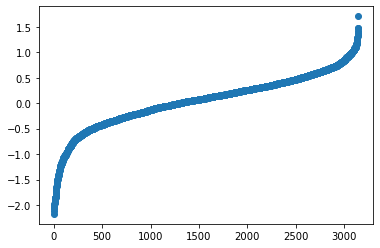

In [412]:
plt.scatter([i for i in range(len(cleaned_df["z_all_06"].sort_values().values))], cleaned_df["z_all_06"].sort_values().values)

(array([ 22.,  29.,  72., 166., 517., 921., 907., 409.,  96.,   6.]),
 array([-2.1753304 , -1.7871083 , -1.3988862 , -1.0106641 , -0.62244195,
        -0.23421985,  0.15400226,  0.54222435,  0.9304465 ,  1.3186686 ,
         1.7068907 ], dtype=float32),
 <BarContainer object of 10 artists>)

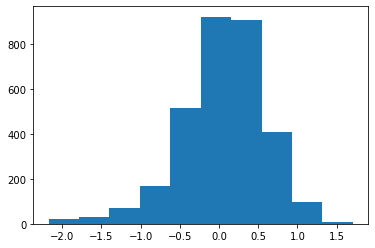

In [413]:
plt.hist(cleaned_df["z_all_06"])

In [414]:
cleaned_df["zall06_cat"] = pd.cut(cleaned_df["z_all_06"],
                               bins=[-np.inf, -0.75, -0.25, 0.25, 0.75, np.inf],
                               labels=[1, 2, 3, 4, 5])

In [415]:
cleaned_df["zall06_cat"].value_counts().sort_values()

1     204
5     212
2     574
4     962
3    1193
Name: zall06_cat, dtype: int64

<a id='models'> </a>
# 2. Selección de modelos

-Regressio
-Random forest
-XGBoost

In [416]:
treatment = 'tr'
outcome = 'z_all_06'
covariates = list(cleaned_df.columns)
covariates.remove(treatment)
covariates.remove(outcome)
covariates.remove("zall06_cat")

In [417]:
cleaned_df.z_all_06.values

array([ 0.45015588,  0.01125175, -0.5053326 , ...,  0.43954134,
        0.03532236, -0.03708899], dtype=float32)

In [418]:
from sklearn.model_selection import train_test_split
# split data into train and test sets 
train, test = train_test_split(cleaned_df, stratify=cleaned_df.zall06_cat, test_size=0.2)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
y_train = train[outcome]
X_train = train[covariates+["tr"]]

X_test = test[covariates+["tr"]]
y_test =  test[outcome]

In [419]:
def display_scores(scores,model_name = None):
    if(model_name):
        print("----",model_name,"----")
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [420]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(X_train,y_train)

 
    # lets comare all of them 
models = [(lin_reg,"lin_reg"),
          (forest_reg,'Random Forest'),
          (xg_reg,"XGboost")]
for model in models:
    scores = cross_val_score(model[0], X_test, y_test, scoring='r2', cv=10)
    display_scores(scores, model[1])
    scores = cross_val_score(model[0], X_test, y_test, scoring='neg_root_mean_squared_error', cv=10)
    display_scores(-scores, model[1])

---- lin_reg ----
Mean: 0.17408242058790413
Standard deviation: 0.18379522522351616
---- lin_reg ----
Mean: 0.4705563675292879
Standard deviation: 0.05836792299639375
---- Random Forest ----
Mean: 0.26393581256392484
Standard deviation: 0.163036642942322
---- Random Forest ----
Mean: 0.4418076227252574
Standard deviation: 0.029712704018989327
---- XGboost ----
Mean: 0.15767320336266719
Standard deviation: 0.1589705715244039
---- XGboost ----
Mean: 0.4744174122810364
Standard deviation: 0.04078338375478946


In [421]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [10, 30, 40], 'max_features': [ 4, 6, 8, 10], 'max_depth':[3,5,7,10, 15]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='r2',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_depth': [3, 5, 7, 10, 15],
                          'max_features': [4, 6, 8, 10],
                          'n_estimators': [10, 30, 40]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='r2')

In [422]:
print("the best parameters are:")
print(grid_search.best_params_)
print("Best Score")
grid_search.best_score_

the best parameters are:
{'max_depth': 10, 'max_features': 10, 'n_estimators': 40}
Best Score


0.3051260482682011

Veamos si otras scores nos proporcionan parámetros óptimos muy diferentes.

In [423]:
grid_search_mse = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_mse.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_depth': [3, 5, 7, 10, 15],
                          'max_features': [4, 6, 8, 10],
                          'n_estimators': [10, 30, 40]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [424]:
print("the best parameters are:")
print(grid_search_mse.best_params_)
print("Best Score")
grid_search_mse.best_score_

the best parameters are:
{'max_depth': 10, 'max_features': 10, 'n_estimators': 40}
Best Score


-0.1924010339151644

Sembla que de totes maneres prediu millor un RF. Fem un gridsearch més pròxim als valors òptims estimats.

In [425]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=42,n_estimators=30,max_depth=20),
                  param_grid={'max_features': range(2, 40, 5)},
                  scoring='neg_root_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)
results = grid_search.cv_results_ 

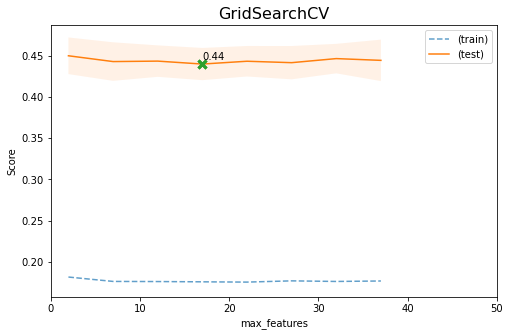

In [426]:
#plot the results
plt.figure(figsize=(8, 5))
plt.title("GridSearchCV",
          fontsize=16)

plt.xlabel("max_features")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 50)


# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_max_features'].data, dtype=float)


for sample, style in (('train', '--'), ('test', '-')):
    sample_score_mean = (-results['mean_%s_score' % (sample)])
    sample_score_std = (results['std_%s_score' % (sample)])
    ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                    sample_score_mean + sample_score_std,
                    alpha=0.1 if sample == 'test' else 0)
    ax.plot(X_axis, sample_score_mean, style,
            alpha=1 if sample == 'test' else 0.7,
            label="(%s)" % ( sample))

best_index = np.nonzero(results['rank_test_score' ] == 1)[0][0]
best_score =  (-results['mean_test_score' ][best_index])

# Plot a dotted vertical line at the best score for that scorer marked by x
ax.plot([X_axis[best_index], ] * 2, [best_score, best_score],
        linestyle='-.',  marker='x', markeredgewidth=3, ms=8)

# Annotate the best score for that scorer
ax.annotate("%0.2f" % best_score,
            (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [427]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(clf, X_train, y_train):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=clf,
        X=X_train,
        y=y_train,
        cv=3,
        scoring="neg_root_mean_squared_error",
        train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    )

    train_mean = -train_scores.mean(axis=1)
    test_mean = -test_scores.mean(axis=1)

    plt.subplots(figsize=(5,4))
    plt.plot(train_sizes, train_mean, label="train")
    plt.plot(train_sizes, test_mean, label="validation")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.legend(loc="best")

    plt.show()

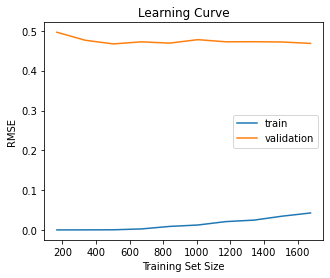

In [430]:
clf=xgb.XGBRegressor()
plot_learning_curve(clf,X_train, y_train)

<a id="hyperRF"> </a>
## 2.A Optimización de hiperparámetros: *Random Forest*

In [443]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 144, 188, 233, 277, 322, 366, 411, 455, 500]}


In [444]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=-1,
                               random_state=42, n_jobs = 1)
# Fit the random search model
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 144, 188, 233,
                                                         277, 322, 366, 411,
                                                         455, 500]},
                   random_state=42, verbose=-1)

In [445]:
rf_random.best_params_

{'n_estimators': 277,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': True}

In [446]:
base_model = RandomForestRegressor( random_state = 42)
scores = cross_val_score(base_model, X_train, y_train, scoring='r2', cv=10)
display_scores(scores, "Base RF (r2)")
scores = cross_val_score(base_model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, "Base RF (rmse)")


best_random = rf_random.best_estimator_
scores = cross_val_score(best_random, X_train, y_train, scoring='r2', cv=10)
display_scores(scores, "Best random RF (r2)")
scores = cross_val_score(best_random, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, "Best random RF (rmse)")

---- Base RF (r2) ----
Mean: 0.3051377614968436
Standard deviation: 0.06680249149084723
---- Base RF (rmse) ----
Mean: 0.43655475090551016
Standard deviation: 0.026951488877928555
---- Best random RF (r2) ----
Mean: 0.3179865904134651
Standard deviation: 0.049060446213599146
---- Best random RF (rmse) ----
Mean: 0.43379479735036564
Standard deviation: 0.02566539147732039


Potser encara podem millorar alguna cosa.

In [451]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [40,50,60],
    'max_features': ["sqrt"],
    'min_samples_leaf': [2,3,4],
    'min_samples_split': [2,4,6],
    'n_estimators': [200, 300, 800, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [452]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

In [ ]:
best_grid= grid_search.best_estimator_
scores = cross_val_score(best_grid, X_train, y_train, scoring='r2', cv=10)
display_scores(scores, "Best grid RF (r2)")
scores = cross_val_score(best_grid, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, "Best grid RF (rmse)")

In [ ]:
best_grid= grid_search.best_estimator_
plot_learning_curve(best_grid, X_train, y_train)

<a id="hyperXG"> </a>
## 2.B Optimización de hiperparámetros: *XGBoost*

In [448]:
import scipy as sp

param_dist = {'boosting_type': ['gbdt', 'dart'],
                    'num_leaves': sp.stats.randint(2, 500),
                    'subsample_for_bin': sp.stats.randint(10, 1001),
                    'min_split_gain': sp.stats.uniform(0, 0.5),
                    'min_child_weight': sp.stats.uniform(1e-6, 1e-2),
                    'reg_alpha': sp.stats.uniform(0, 1e-2),
                    'reg_lambda': sp.stats.uniform(0, 1e-2),
                    'application': ['regression_l2'],
                    'subsample_freq': sp.stats.randint(1, 11),
                    'subsample': sp.stats.uniform(1e-3, 0.99),
                    'colsample_bytree': sp.stats.uniform(1e-3, 0.5),
                    'learning_rate': sp.stats.uniform(1e-6, 0.3),
                    'max_depth': sp.stats.randint(-1, 200),
                    'n_estimators': sp.stats.randint(100, 1000),
                    'extra_trees':[True]
                 }

In [449]:
lgbm = lgb.LGBMRegressor(objective='regression', n_jobs=1)
rscv = RandomizedSearchCV(
                              estimator=lgbm,
                              param_distributions=param_dist,
                              cv=3,
                              n_iter=100,
                              n_jobs=4,
                              verbose=1,
                              refit=True,
                            )
rscv = rscv.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [453]:
rscv.best_params_

{'application': 'regression_l2',
 'boosting_type': 'dart',
 'colsample_bytree': 0.3429643257220632,
 'extra_trees': True,
 'learning_rate': 0.10180460185942476,
 'max_depth': 191,
 'min_child_weight': 1.964577986653959e-05,
 'min_split_gain': 0.06213079963399726,
 'n_estimators': 996,
 'num_leaves': 278,
 'reg_alpha': 0.009518636009640057,
 'reg_lambda': 0.0015073210482326516,
 'subsample': 0.8929615581731233,
 'subsample_for_bin': 638,
 'subsample_freq': 1}

In [454]:
base_lightgbm =lgb.LGBMRegressor()
scores = cross_val_score(base_lightgbm, X_train, y_train, scoring='r2', cv=10)
display_scores(scores, "Base LightGBM (r2)")
scores = cross_val_score(base_lightgbm, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, "Base LightGBM (rmse)")

best_lightgbm= rscv.best_estimator_
scores = cross_val_score(best_ligthGBM, X_train, y_train, scoring='r2', cv=10)
display_scores(scores, "Best random grid lightGBM (r2)")
scores = cross_val_score(best_ligthGBM, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, "Best random grid lightGBM (rmse)")

---- Base LightGBM (r2) ----
Mean: 0.29872779733703064
Standard deviation: 0.06203692102095203
---- Base LightGBM (rmse) ----
Mean: 0.43850540312127817
Standard deviation: 0.02415326055841157
---- Best random grid lightGBM (r2) ----
Mean: 0.3235051068639046
Standard deviation: 0.04956000433368016
---- Best random grid lightGBM (rmse) ----
Mean: 0.43107917340440977
Standard deviation: 0.025415973371694087


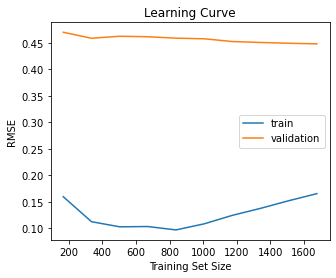

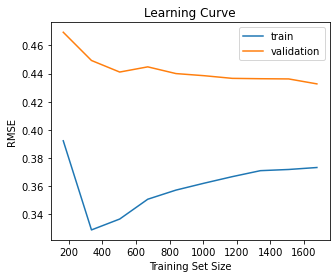

In [455]:
plot_learning_curve(base_lightgbm, X_train, y_train)
plot_learning_curve(best_lightgbm, X_train, y_train)

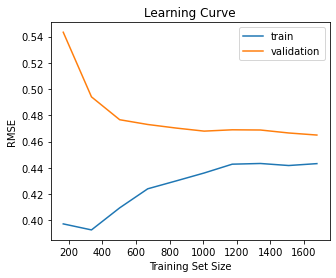

In [456]:
plot_learning_curve(lin_reg, X_train, y_train)

(-3.0, 2.0)

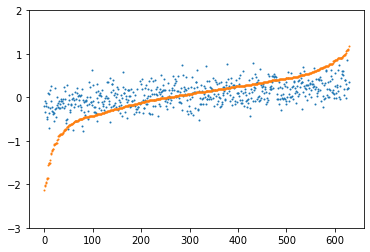

In [457]:
lin_reg.fit(X_train, y_train)
y_pred=lin_reg.predict(X_test)
predicted=pd.DataFrame(y_pred, columns=["y_pred"])
predicted["y_true"]=y_test.values
predicted.sort_values(by="y_true", inplace=True)
plt.scatter([i for i in range(len(y_pred))], predicted.y_pred, s=1)
plt.scatter([i for i in range(len(y_pred))], predicted.y_true.values, s=1)
plt.ylim(-3,2)

(-3.0, 2.0)

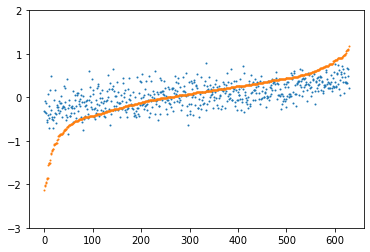

In [458]:
best_lightgbm.fit(X_train, y_train)
y_pred=best_lightgbm.predict(X_test)
predicted=pd.DataFrame(y_pred, columns=["y_pred"])
predicted["y_true"]=y_test.values
predicted.sort_values(by="y_true", inplace=True)
plt.scatter([i for i in range(len(y_pred))], predicted.y_pred, s=1)
plt.scatter([i for i in range(len(y_pred))], predicted.y_true.values, s=1)
plt.ylim(-3,2)

### INTENTEM AFEGIR POLYNOMIAL FEATURES

In [459]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
X_train1=poly.fit_transform(X_train)
X_test1=poly.transform(X_test)

In [461]:
X_train1.shape

(2516, 1128)

In [460]:
best_lightgbm.fit(X_train1, y_train)
y_pred=best_lightgbm.predict(X_test1)
predicted=pd.DataFrame(y_pred, columns=["y_pred"])
predicted["y_true"]=y_test.values
predicted.sort_values(by="y_true", inplace=True)
plt.scatter([i for i in range(len(y_pred))], predicted.y_pred, s=1)
plt.scatter([i for i in range(len(y_pred))], predicted.y_true.values, s=1)
plt.ylim(-3,2)

KeyboardInterrupt: 

In [ ]:
base_lightgbm =lgb.LGBMRegressor()
scores = cross_val_score(base_lightgbm, X_train1, y_train, scoring='r2', cv=10)
display_scores(scores, "Base LightGBM (r2)")
scores = cross_val_score(base_lightgbm, X_train1, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, "Base LightGBM (rmse)")

best_lightgbm= rscv.best_estimator_
scores = cross_val_score(best_ligthGBM, X_train1, y_train, scoring='r2', cv=10)
display_scores(scores, "Best random grid lightGBM (r2)")
scores = cross_val_score(best_ligthGBM, X_train1, y_train, scoring="neg_root_mean_squared_error", cv=10)
display_scores(-scores, "Best random grid lightGBM (rmse)")

<a id="ITE"> </a>
# 3. Cálculo del ITE

Creem els contrafatuals i tot per predir la ITE

In [ ]:
counterfactual_df=cleaned_df.drop("z_all_06",axis=1)

In [ ]:
counterfactual_df.tr

In [ ]:
a=counterfactual_df["tr"]+1

In [ ]:
counterfactual_df["tr"]=a%2

In [ ]:
counterfactual_df.tr

In [ ]:
counterfactual=forest_reg.predict(counterfactual_df)

In [ ]:
observed=cleaned_df["z_all_06"]
counterfactuals=pd.Series(counterfactual, index=observed.index)

In [ ]:
observed

In [ ]:
ite_temp=pd.Series([observed[i]-counterfactuals[i] for i in observed.index if cleaned_df.tr[i]==1], index=cleaned_df[cleaned_df.tr==1].index)
ite_temp1=pd.Series([counterfactuals[i]-observed[i] for i in observed.index if cleaned_df.tr[i]==0], index=cleaned_df[cleaned_df.tr==0].index)
ite=pd.concat([ite_temp,ite_temp1])
ite.sort_index(inplace=True)

In [ ]:
ite.describe()

In [ ]:
import seaborn as sb

sb.histplot(ite)

In [ ]:
cleaned_df.z_all_06.describe()

NO CONSIDERAR: ite amb counterfactual i observed predits pel model

In [ ]:
observed_df=cleaned_df.drop("z_all_06",axis=1)
observed_predict=forest_reg.predict(observed_df)
observed_predict=pd.Series(observed_predict, index=observed_df.index)

In [ ]:
ite1=[observed_predict[i]-counterfactuals[i] for i in observed_predict.index if cleaned_df.tr[i]==1]+[counterfactuals[i]-observed_predict[i] for i in observed_predict.index if cleaned_df.tr[i]==0 ]

In [ ]:
ite1=pd.Series(ite1, index=cleaned_df.index)
ite1.describe()

In [ ]:
sb.histplot(ite1)

In [ ]:
ite1.value_counts()

<a id="Tree"> </a>

# 4. Agrupación por ITE: *Decision Tree*

Quartils i std.

1. Separem <=q25, q25<...<=q50, q50<=q75, q75<
2. STD

In [ ]:
quartils=ite.quantile([0.25,0.5, 0.75])

In [ ]:
ite0=ite[ite<=quartils.iloc[0]]

In [ ]:
ite1=ite[ite<=quartils.iloc[1]]
ite1.drop(ite0.index, inplace=True)

In [ ]:
ite2=ite[ite<=quartils.iloc[2]]
ite2.drop(ite0.index, inplace=True)
ite2.drop(ite1.index, inplace=True)

In [ ]:
ite3=ite.copy()
ite3.drop(ite0.index, inplace=True)
ite3.drop(ite1.index, inplace=True)
ite3.drop(ite2.index, inplace=True)

In [ ]:
ite0_df=cleaned_df.loc[ite0.index]
ite1_df=cleaned_df.loc[ite1.index]
ite2_df=cleaned_df.loc[ite2.index]
ite3_df=cleaned_df.loc[ite3.index]

In [ ]:
shap=[[stats.shapiro(ite0_df[col].values).pvalue for col in normal_cols],
        [stats.shapiro(ite1_df[col].values).pvalue for col in normal_cols],
        [stats.shapiro(ite2_df[col].values).pvalue for col in normal_cols],
        [stats.shapiro(ite3_df[col].values).pvalue for col in normal_cols]]

shap_df=pd.DataFrame(shap,columns=normal_cols)

In [ ]:
#fem el test de shapiro a els subgrups (generats al estratificar la ite en quartils) de les variables normals. 
#Surt normalitat arreu, aixi que si tenen desv std entre ells normals, podrem aplicar t-tests per comprovar 
#si les mitjanes son iguals
shap_df

In [ ]:
std=[[np.std(ite0_df[col].values) for col in normal_cols],
        [np.std(ite1_df[col].values) for col in normal_cols],
        [np.std(ite2_df[col].values) for col in normal_cols],
        [np.std(ite3_df[col].values) for col in normal_cols]]
std_df=pd.DataFrame(std,columns=normal_cols)

In [ ]:
std_df

In [ ]:
ite0_df[normal_cols].describe()

In [ ]:
ite3_df[normal_cols].describe()

In [ ]:
import scipy
from scipy import stats
    
ttestp_df=[[stats.ttest_ind(ite1_df[col].values, ite0_df[col].values).pvalue for col in normal_cols],
          [stats.ttest_ind(ite2_df[col].values, ite0_df[col].values).pvalue for col in normal_cols],
          [stats.ttest_ind(ite3_df[col].values, ite0_df[col].values).pvalue for col in normal_cols],
          [stats.ttest_ind(ite2_df[col].values, ite1_df[col].values).pvalue for col in normal_cols],
          [stats.ttest_ind(ite3_df[col].values, ite1_df[col].values).pvalue for col in normal_cols],
          [stats.ttest_ind(ite3_df[col].values, ite2_df[col].values).pvalue for col in normal_cols]
         ]
ttest_df=pd.DataFrame(ttestp_df,columns=normal_cols, index=["0-1","0-2","0-3","1-2","1-3","2-3"])

In [ ]:
#si p<0.05 podem assumir que les mitjanes son diferents (descartem la hipotesi nulla)
ttest_df.style.background_gradient(cmap="Blues")

<a id="CATE"> </a>

# 5. Cálculo de CATEs